loading data...
Data Loaded: 8567 bars from 2022-01-01 01:00:00 to 2025-11-28 21:00:00
Running Backtest...
Strategy Performance Report
Final Capital: $12215.51
Total Return : 22.16%
Total Trades : 170
Win Rate     : 52.35%
Max Drawdown : -28.91%
Avg PnL      : 0.38%


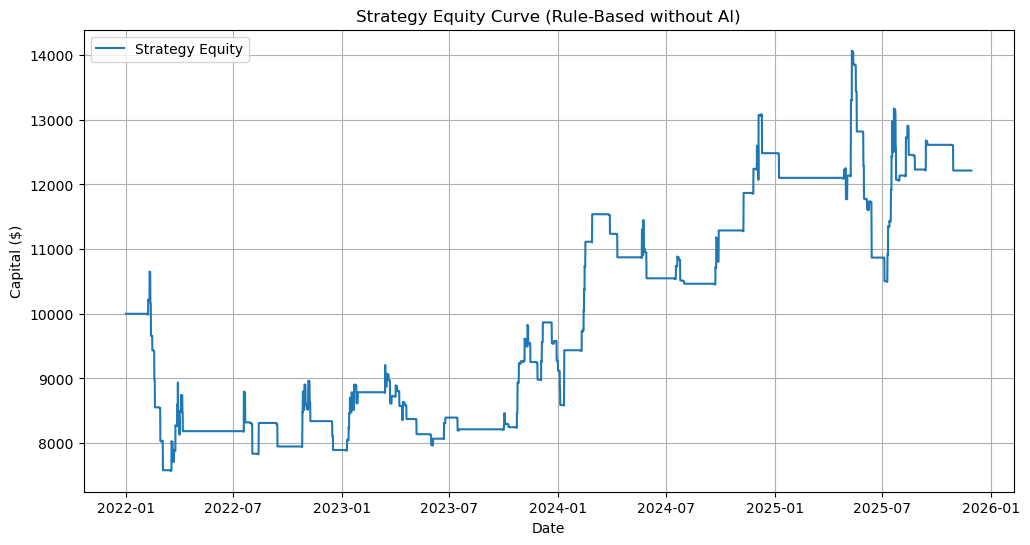

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class LogicBacktester:
    def __init__(self, price_path, feature_path, initial_capital=10000, fee_rate=0.001):
        self.price_path = price_path
        self.feature_path = feature_path
        self.initial_capital = initial_capital
        self.fee_rate = fee_rate # 진입/청산 각각 적용 (왕복 약 0.2%)
        self.df = None
        self.trades = []
        self.equity_curve = []
        
    def load_and_merge(self):
        # 1. 데이터 로드
        print("loading data...")
        price_df = pd.read_csv(self.price_path)
        feat_df = pd.read_csv(self.feature_path)
        
        # 2. 날짜 변환 및 정렬
        price_df['date'] = pd.to_datetime(price_df['date'])
        feat_df['date'] = pd.to_datetime(feat_df['date'])
        price_df=price_df[price_df['date']>="2022-01-01"]
        feat_df=feat_df[feat_df['date']>="2022-01-01"]
        # 3. 데이터 병합 (Inner Join)
        # raw_price의 OHLCV와 feature의 지표들을 합침
        self.df = pd.merge(price_df, feat_df, on='date', how='inner').sort_values('date').reset_index(drop=True)
        
        # 데이터 유효성 확인 (결측치 제거)
        self.df.dropna(subset=['REGIME_SMA200', 'lido_eth_tvl_1d_chg', 'ETH_KP_Zscore', 'ATR_84', 'ADX_14'], inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        print(f"Data Loaded: {len(self.df)} bars from {self.df['date'].iloc[0]} to {self.df['date'].iloc[-1]}")

    def run_backtest(self):
        capital = self.initial_capital
        position = None # None, 'long'
        entry_price = 0
        entry_index = 0
        stop_loss = 0
        take_profit = 0
        
        # 성과 기록용
        self.equity_curve = [capital]
        
        print("Running Backtest...")
        
        for i in range(len(self.df) - 1):
            curr_bar = self.df.iloc[i]
            next_bar = self.df.iloc[i+1] # 체결은 다음 봉 시가 혹은 꼬리에서 발생
            
            # 1. 현재 포지션이 없는 경우 (진입 탐색)
            if position is None:
                # ==========================================
                # [전략 로직] 여기가 핵심입니다.
                # ==========================================
                is_uptrend = curr_bar['REGIME_SMA200'] == 1       # 장기 상승 추세
                is_money_in = curr_bar['lido_eth_tvl_1d_chg'] > 0 # 스마트머니 유입 (Lido TVL)
                is_not_overheated = curr_bar['ETH_KP_Zscore'] < 0.0# 김프 과열 아님
                is_trend_strong = curr_bar['ADX_14'] >20       # 추세 강도 확보
                
                if is_uptrend and is_money_in and is_not_overheated and is_trend_strong:
                    # 다음 봉 시가(Open)로 진입 가정
                    entry_price = next_bar['ETH_Open']
                    atr = curr_bar['ATR_84']
                    
                    # ATR 기반 TP/SL 설정
                    stop_loss = entry_price - (atr * 2.0)   # 손절: 2.0 ATR
                    take_profit = entry_price + (atr * 3.0) # 익절: 3.0 ATR (손익비 1.5)
                    
                    position = 'long'
                    entry_index = i + 1
                    
                    # 진입 수수료 차감
                    capital *= (1 - self.fee_rate)
            
            # 2. 포지션 보유 중인 경우 (청산 탐색: Triple Barrier)
            elif position == 'long':
                # 다음 봉의 Low가 SL을 건드렸나?
                if next_bar['ETH_Low'] <= stop_loss:
                    exit_price = stop_loss # 슬리피지 고려 시 더 낮을 수 있음 (여기선 지정가 가정)
                    pnl = (exit_price - entry_price) / entry_price
                    capital *= (1 + pnl) * (1 - self.fee_rate) # 청산 수수료 포함
                    
                    self.trades.append({
                        'entry_date': self.df.iloc[entry_index]['date'],
                        'exit_date': next_bar['date'],
                        'type': 'SL',
                        'pnl': pnl,
                        'holding_bars': (i + 1) - entry_index
                    })
                    position = None
                
                # 다음 봉의 High가 TP를 건드렸나?
                elif next_bar['ETH_High'] >= take_profit:
                    exit_price = take_profit
                    pnl = (exit_price - entry_price) / entry_price
                    capital *= (1 + pnl) * (1 - self.fee_rate)
                    
                    self.trades.append({
                        'entry_date': self.df.iloc[entry_index]['date'],
                        'exit_date': next_bar['date'],
                        'type': 'TP',
                        'pnl': pnl,
                        'holding_bars': (i + 1) - entry_index
                    })
                    position = None
                    
                # 만약 너무 오래 횡보하면 강제 청산 (Time Barrier - 옵션)
                elif ((i + 1) - entry_index) > 12: # 48봉 = 8일
                    exit_price = next_bar['ETH_Close']
                    pnl = (exit_price - entry_price) / entry_price
                    capital *= (1 + pnl) * (1 - self.fee_rate)
                    
                    self.trades.append({
                        'entry_date': self.df.iloc[entry_index]['date'],
                        'exit_date': next_bar['date'],
                        'type': 'TimeExit',
                        'pnl': pnl,
                        'holding_bars': (i + 1) - entry_index
                    })
                    position = None

            self.equity_curve.append(capital)

    def analyze_performance(self):
        if not self.trades:
            print("No trades executed.")
            return

        trades_df = pd.DataFrame(self.trades)
        total_trades = len(trades_df)
        win_trades = trades_df[trades_df['pnl'] > 0]
        win_rate = len(win_trades) / total_trades * 100
        
        total_return = (self.equity_curve[-1] - self.initial_capital) / self.initial_capital * 100
        
        # MDD 계산
        equity_series = pd.Series(self.equity_curve)
        peak = equity_series.cummax()
        drawdown = (equity_series - peak) / peak
        mdd = drawdown.min() * 100
        
        print("="*30)
        print(f"Strategy Performance Report")
        print("="*30)
        print(f"Final Capital: ${self.equity_curve[-1]:.2f}")
        print(f"Total Return : {total_return:.2f}%")
        print(f"Total Trades : {total_trades}")
        print(f"Win Rate     : {win_rate:.2f}%")
        print(f"Max Drawdown : {mdd:.2f}%")
        print(f"Avg PnL      : {trades_df['pnl'].mean()*100:.2f}%")
        print("="*30)
        
        # 시각화
        plt.figure(figsize=(12, 6))
        plt.plot(self.df['date'].iloc[:len(self.equity_curve)], self.equity_curve, label='Strategy Equity')
        plt.title('Strategy Equity Curve (Rule-Based without AI)')
        plt.xlabel('Date')
        plt.ylabel('Capital ($)')
        plt.grid(True)
        plt.legend()
        plt.show()

# ====================================================
# 실행 코드 (파일 경로를 실제 환경에 맞게 수정하세요)
# ====================================================
# 파일이 있다고 가정하고 실행
backtester = LogicBacktester('eth_4hour_raw_price.csv', 'eth_4hour_feature.csv')
backtester.load_and_merge()
backtester.run_backtest()
backtester.analyze_performance()


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class FinalStrategyBacktester:
    def __init__(
        self,
        price_path,
        feature_path,
        initial_capital=1_000_000,
        fee_rate=0.0005,
        risk_pct=0.5,       # 공격적으로 2% 리스크 (자신 없으면 0.01)
        size_tick=0.0001,    # ETH 최소 거래 단위
    ):
        self.price_path = price_path
        self.feature_path = feature_path
        self.initial_capital = initial_capital
        self.fee_rate = fee_rate
        self.risk_pct = risk_pct
        self.size_tick = size_tick

        self.df = None
        self.trades = []
        self.equity_curve = []

    def load_and_merge(self):
        print("Loading data...")
        try:
            price_df = pd.read_csv(self.price_path)
            feat_df = pd.read_csv(self.feature_path)
        except FileNotFoundError:
            print("❌ 파일을 찾을 수 없습니다.")
            return

        price_df['date'] = pd.to_datetime(price_df['date'])
        feat_df['date'] = pd.to_datetime(feat_df['date'])

        # 2021년 이후 데이터 권장
        start_date = "2021-01-01"
        price_df = price_df[price_df['date'] >= start_date]
        feat_df = feat_df[feat_df['date'] >= start_date]

        self.df = pd.merge(price_df, feat_df, on='date', how='inner').sort_values('date').reset_index(drop=True)
        
        # 필수 컬럼 체크 및 결측치 제거
        req = ['ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close', 'REGIME_SMA200', 
               'return_lag_6p', 'ETH_KP_Zscore', 'ATR_84', 'RSI_84']
        self.df.dropna(subset=req, inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        
        print(f"✅ Data Loaded: {len(self.df)} bars")

    def run_backtest(self):
        if self.df is None: return

        cash = self.initial_capital
        position_size = 0.0
        position = None
        entry_price = 0.0
        entry_index = 0
        
        # 트레일링 스탑용 변수
        stop_price = 0.0
        highest_price = 0.0

        self.equity_curve = [cash]
        
        print("🚀 Running Final Backtest (Multi-Door + Trailing Stop + Risk Mgmt)...")

        for i in range(len(self.df) - 1):
            curr_bar = self.df.iloc[i]
            next_bar = self.df.iloc[i + 1]

            # ----------------------------------------
            # 1. 진입 (Entry) - 문 2개
            # ----------------------------------------
            if position is None:
                atr = float(curr_bar['ATR_84'])
                
                # Door 1: 상승장 + 단기 급락 (건전한 조정)
                cond_trend = curr_bar['REGIME_SMA200'] == 1
                cond_dip = curr_bar['return_lag_6p'] < -0.02
                cond_val = curr_bar['ETH_KP_Zscore'] < 0.0
                signal_1 = cond_trend and cond_dip and cond_val
                
                # Door 2: 하락장 + 투매 (패닉 바잉)
                cond_panic = curr_bar['ETH_KP_Zscore'] < -2.0
                cond_rsi = curr_bar['RSI_84'] < 40
                signal_2 = cond_panic and cond_rsi
                
                if signal_1 or signal_2:
                    entry_price = float(next_bar['ETH_Open'])
                    
                    # 초기 손절가: 진입가 - 2 ATR
                    stop_price = entry_price - (atr * 2.0)
                    per_unit_risk = entry_price - stop_price
                    
                    if per_unit_risk <= 0: continue

                    # [자금 관리 핵심] 리스크 % 기반 수량 계산
                    risk_amount = cash * self.risk_pct
                    raw_size = risk_amount / per_unit_risk
                    position_size = np.floor(raw_size / self.size_tick) * self.size_tick
                    
                    if position_size <= 0: continue
                    
                    notional = position_size * entry_price
                    fee = notional * self.fee_rate
                    
                    if notional + fee > cash: continue # 현금 부족시 스킵

                    cash -= (notional + fee)
                    position = 'long'
                    entry_index = i + 1
                    highest_price = entry_price # 최고가 초기화

            # ----------------------------------------
            # 2. 청산 (Exit) - 트레일링 스탑
            # ----------------------------------------
            elif position == 'long':
                current_high = float(next_bar['ETH_High'])
                current_low = float(next_bar['ETH_Low'])
                atr = float(curr_bar['ATR_84'])
                
                # A. 최고가 갱신 및 스탑라인 상향 (Trailing)
                if current_high > highest_price:
                    highest_price = current_high
                    # 최고가 대비 -3 ATR 지점을 새로운 방어선으로
                    new_stop = highest_price - (atr * 3.0)
                    if new_stop > stop_price:
                        stop_price = new_stop
                
                # B. 스탑 로스 터치? (익절이든 손절이든 여기서 처리)
                exit_price = None
                exit_type = None
                
                if current_low <= stop_price:
                    exit_price = stop_price
                    # 갭락 보정 (시가가 이미 스탑보다 낮으면 시가 청산)
                    if next_bar['ETH_Open'] < stop_price:
                        exit_price = float(next_bar['ETH_Open'])
                    exit_type = 'TrailingStop'
                
                # C. 시간 초과 (좀비 포지션 정리 - 10일)
                elif (i + 1) - entry_index > 30:
                    exit_price = float(next_bar['ETH_Close'])
                    exit_type = 'TimeExit'
                
                # 청산 실행
                if exit_price is not None:
                    proceed = position_size * exit_price
                    fee = proceed * self.fee_rate
                    cash += (proceed - fee)
                    
                    pnl_ratio = (exit_price - entry_price) / entry_price
                    
                    self.trades.append({
                        'date': next_bar['date'],
                        'type': exit_type,
                        'pnl': pnl_ratio,
                        'entry': entry_price,
                        'exit': exit_price,
                        'holding': (i + 1) - entry_index
                    })
                    
                    position = None
                    position_size = 0.0

            # 자산 평가
            current_val = cash
            if position == 'long':
                current_val += position_size * float(self.df.iloc[i+1]['ETH_Close'])
            self.equity_curve.append(current_val)

    def analyze_performance(self):
        if not self.trades:
            print("❌ 거래가 없습니다.")
            return

        trades_df = pd.DataFrame(self.trades)
        total_trades = len(trades_df)
        win_rate = len(trades_df[trades_df['pnl'] > 0]) / total_trades * 100
        total_return = (self.equity_curve[-1] - self.initial_capital) / self.initial_capital * 100
        
        # MDD
        equity_series = pd.Series(self.equity_curve)
        peak = equity_series.cummax()
        mdd = ((equity_series - peak) / peak).min() * 100
        
        print("\n" + "="*40)
        print(f"🔥 FINAL STRATEGY RESULT")
        print("="*40)
        print(f"최종 자산 : {self.equity_curve[-1]:,.0f} KRW")
        print(f"총 수익률 : {total_return:.2f}%")
        print(f"거래 횟수 : {total_trades}회")
        print(f"승률     : {win_rate:.2f}%")
        print(f"MDD      : {mdd:.2f}%")
        print(f"평균 손익 : {trades_df['pnl'].mean()*100:.2f}%")
        print("="*40)
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.df['date'].iloc[:len(self.equity_curve)], self.equity_curve, color='red')
        plt.title('Final Strategy Equity Curve')
        plt.yscale('log') # 로그 스케일로 보면 복리 효과가 더 잘 보입니다
        plt.grid(True, alpha=0.3)
        plt.show()

# 실행
file_price = 'eth_4hour_raw_price.csv'
file_features = 'eth_4hour_feature.csv'

tester = FinalStrategyBacktester(file_price, file_features, risk_pct=0.02) # 2% 리스크
tester.load_and_merge()
tester.run_backtest()
tester.analyze_performance()

Loading data...
✅ Data Loaded: 10757 bars
🚀 Running Final Backtest (Multi-Door + Trailing Stop + Risk Mgmt)...

🔥 FINAL STRATEGY RESULT
최종 자산 : 1,402,326 KRW
총 수익률 : 40.23%
거래 횟수 : 93회
승률     : 46.24%
MDD      : -19.37%
평균 손익 : 1.29%
